In [ ]:
For upload to github.


Message passing for weighted tree graph


In [2]:
import math
import ipywidgets as widgets
import numpy as np
import copy

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

In [24]:
def MP_weighted(G, nodes_infected, T_max=5, num_T_positions=10):
    """
    Args:
        G:  an undirected graph constructed by networkx, with edge property 'weight' storing the edge weight.
        nodes_infected: a set of infected nodes.
        T_max: upbound of observation/spreading time considered
        num_T_positions: used for decides T_positions=[i for i in range(1, num_T_positions+1)], and the optimization will search over observation time [T_max*t_pos/num_T_positions for t_pos in T_positions]
    Returns:
        
    
    """
       
    
    #### draw the graph G
    pos_SEED=0
    
    edge_labels = nx.get_edge_attributes(G,'weight')
    # Set the node colors
    node_colors = ['gray' if i in nodes_infected else 'white' for i in range(G.number_of_nodes())]

    # Draw the graph
    pos = nx.spring_layout(G, seed=pos_SEED)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors= 'black')
    nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in range(G.number_of_nodes())}, font_size=12)
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.axis('off')
    plt.show()
    
    
    #### Construct the parent and child relation between nodes after selecting a node as source
    
    source=0
    parent={} # 'key:value' pair where 'value' is the parent node for node 'key'
    child={} #'key:value' pair where 'value' is the set of child nodes for node 'key'
    depth={} # 
    nodes_waiting_child=set() # nodes haven't assigned child
    b_uninfected=set() #susceptible nodes at final observation; uninfected nodes which have infected neighbors
    b_infected=set() #infected nodes which have uninfected neighbors
    leaf_infected=set() # the leaf infected nodes

    parent[source]=None
    depth[source]=0
    nodes_waiting_child.add(source)
    while len(nodes_waiting_child)!=0:
        i=nodes_waiting_child.pop()
        child[i]= set(j for j in G.neighbors(i) if j not in parent.keys())
        is_leaf = True
        for j in child[i]:
            parent[j]=i
            if j in nodes_infected:
                depth[j]=depth[i]+1
                nodes_waiting_child.add(j)
                is_leaf = False
            else:
                b_uninfected.add(j)
                b_infected.add(i)
        if is_leaf==True:
            leaf_infected.add(i)    
            
    #### get some variable aiding the judgement whether a node received all messages from its child nodes
    static_num_child_not_ready={}
    static_nodes_ready=set() # nodes whose children nodes all can be ready with messages, i.e. nodes that have no child nodes 
    static_nodes_received=set()

    # only deal with infected nodes, since uninfected nodes in b_uninfected is always ready
    for i in nodes_infected:

        if len(child[i])==0:
            static_num_child_not_ready[i]=0
            static_nodes_ready.add(i)
        else:
            static_num_child_not_ready[i]=len(child[i])
            
    
    ## Discrete FFT for convolution of a and b
    def rfft_convolve(a, b):
        ''' return discrete convolution array of arrays a and b by fft
        '''
        #here we only deal with the case len(a)==len(b)
        if len(a)!=len(b):
            print("Warning. The arrays a and b in fft has different lenghth")
        n = len(a) + len(b) -1
        N = 2 ** (int(np.log2(n))+1)
        A = np.fft.rfft(a, N)
        B = np.fft.rfft(b, N)
        return np.fft.irfft(A*B)[:(n+1)//2]
    
    #### message passing for the source node given by initiallization 
    #### T_max=5

    ####T_positions=[i for i in range(1,11)]
    T_positions=[i for i in range(1, num_T_positions+1)]

    message=[None]*(len(T_positions)+1)
    result=[None]*(len(T_positions)+1)


    for t_pos in T_positions:
        num_child_not_ready=static_num_child_not_ready.copy()
        nodes_ready=static_nodes_ready.copy()
        nodes_received=static_nodes_received.copy()

        message[t_pos]={}
        result[t_pos]={}

        T=T_max*t_pos/len(T_positions) # total time, or observation time
        num_intervals=20
        t_of_T=[T/num_intervals*i for i in range(0, num_intervals+1)]

        # currently nodes_ready are infected nodes with no child nodes
        nodes_no_child=nodes_ready.copy()
        nodes_received=nodes_ready.copy()
        nodes_ready=set()
        while len(nodes_no_child)!=0: 
            i=nodes_no_child.pop()
            message[t_pos][i]=[1-math.exp(-G[i][parent[i]]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
            i_p=parent[i]
            num_child_not_ready[i_p]-=1
            if num_child_not_ready[i_p] == 0:
                nodes_ready.add(i_p)

        for i in b_uninfected:
            message[t_pos][i]=[math.exp(-G[i][parent[i]]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
            i_p=parent[i]
            num_child_not_ready[i_p]-=1
            if num_child_not_ready[i_p] == 0:
                nodes_ready.add(i_p)

        while len(nodes_ready)!=0:
            i=nodes_ready.pop()
            nodes_received.add(i)
            message[t_pos][i]=[]

            if parent[i] is not None:
                child_product=np.array([1]*len(t_of_T))
                for k in child[i]:
                    child_product=np.multiply(child_product, np.array(message[t_pos][k]))
                i_pdf=[G[i][parent[i]]['weight'] * math.exp(-G[i][parent[i]]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
                for j in range(0, num_intervals+1):
                    ## not use fft
                    message[t_pos][i].append(np.sum(np.multiply(child_product[::-1][:j+1], np.array(i_pdf)[:j+1]))*T/num_intervals)
                    ##use fft  
                    # message[t_pos][i].append(rfft_convolve(child_product[num_intervals-j:], i_pdf[:j+1])[::-1][0]*T/num_intervals)


                i_p=parent[i]
                num_child_not_ready[i_p]-=1
                if num_child_not_ready[i_p] == 0:
                    nodes_ready.add(i_p)    
            else:
                root_product=1
                for k in child[i]:
                    if k in nodes_infected:
                        root_product=root_product*np.sum(message[t_pos][k])*T/num_intervals
                    else:
                        root_product=root_product*message[t_pos][k][num_intervals] # because for susceptible nodes in b_uninfected, we calculated its CDF in its message[t_pos]

                result[t_pos][source]=root_product.copy()
                
                
    
    ## To compute likelihood probability for other nodes 
    message_from_parent=[None]*(len(T_positions)+1)


    for t_pos in T_positions:
        ## do not forgot the T and t_of_T when "for t_pos in T_positions" is separated to two part
        T=T_max*t_pos/len(T_positions) # total time
        t_of_T=[T/num_intervals*i for i in range(0, num_intervals+1)]


        message_from_parent[t_pos]={}
        nodes_to_compute=[i for i in child[source] if i in nodes_infected]
        while len(nodes_to_compute)!=0:
            i=nodes_to_compute.pop()
            i_p=parent[i]

            message_from_parent[t_pos][i]=[]
            # calculate the product of messages from neighbors of i_p except i 
            child_product=np.array([1]*len(t_of_T))
            child_i_p_exclude_i = child[i_p].copy()
            child_i_p_exclude_i.remove(i)
            for k in child_i_p_exclude_i:
                child_product=np.multiply(child_product, np.array(message[t_pos][k]))
            # parent[i_p] is not None means i is not connected to the source
            if parent[i_p] is not None:
                child_product=np.multiply(child_product, np.array(message_from_parent[t_pos][i_p]))

            # message_from_parent[t_pos][i] is the message i_p should send to i
            i_pdf=[G[i][i_p]['weight'] * math.exp(-G[i][i_p]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
            for j in range(0, num_intervals+1):
                ## not use fft
                message_from_parent[t_pos][i].append(np.sum(np.multiply(child_product[::-1][:j+1], np.array(i_pdf)[:j+1]))*T/num_intervals)
                ##use fft  
                # message_from_parent[t_pos][i].append(rfft_convolve(child_product[num_intervals-j:], i_pdf[:j+1])[::-1][0]*T/num_intervals)            

            # calculate the probability as if i is the root (source), for message from i_p, should use message_from_parent[t_pos][i]
            root_product=1
            root_product=root_product*np.sum(message_from_parent[t_pos][i])*T/num_intervals
            for k in child[i]:
                if k in nodes_infected:
                    root_product=root_product*np.sum(message[t_pos][k])*T/num_intervals
                else:
                    root_product=root_product*message[t_pos][k][num_intervals] # because for susceptible nodes in b_uninfected, we calculated its CDF in its message
            # print(t_pos, len(result),result[t_pos])
            result[t_pos][i]=root_product.copy()

             # nodes_no_result.remove(i)
            nodes_to_compute=nodes_to_compute + [j for j in child[i] if j in nodes_infected]                
                
                
    
    #### processing the results
    ## store the likelyhood with nodes as keys of a dict. 'result_by_node[i][j]' is the likehood for node i to be the source when observation time is the T_positions[j]-th observation time
    result_by_node={}
    for i in nodes_infected:
        result_by_node[i]=[]
        for t_pos in T_positions:
            result_by_node[i].append(result[t_pos][i]) # pay attention that the index 0 correspond to t_pos=1

    ## 'max_nodes_t_pos' is a dict; max_nodes_t_pos[i][j] is an integer such that at max_nodes_t_pos[i][j]-th observation time is when node i achives largest likelyhood probability to be the source over all the ovservation times
    ## 'max_node' are the node has the largest likelyhood probability to be the source, and 'max_value' is the value.
    max_nodes_t_pos={}
    max_value=0
    max_nodes=set()

    for k,v in result_by_node.items():
        max_index=np.argmax(v)
        max_nodes_t_pos[k]=max_index+1
        if np.isclose(v[max_index],max_value):
            max_nodes.add(k)
        elif v[max_index]>max_value:               
            max_value=v[max_index]
            max_nodes={k}

    # print(max_nodes_t_pos)
    print('The most likely source nodes are:', max_nodes, '\n', 'the corresponding likelyhood probability value is', max_value, '\n', 
              'the index of the ovservation time correspond to node', list(max_nodes)[0], ' is ', max_nodes_t_pos[list(max_nodes)[0]])

    ## result_by_t_pos[i][j] is the likelyhood probability for node j to be the source at i-th observation time.
    result_by_t_pos={}
    # pay attention that the index 0 correspond to t_pos=1
    for t_pos in T_positions:
        result_by_t_pos[t_pos]=[]
        for k in G.nodes():
            result_by_t_pos[t_pos].append(result_by_node[k][t_pos-1] if k in nodes_infected else 0)

    colors_dict=copy.deepcopy(result_by_t_pos)
    norm = mpl.colors.Normalize(vmin=0, vmax=max_value, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)

    def plot_result_by_t_pos(t_pos_for_plot):
        nx.draw(G, pos=pos, node_color=[mapper.to_rgba(i) for i in colors_dict[t_pos_for_plot]], with_labels=True)
        plt.show()


    widgets.interact(plot_result_by_t_pos,t_pos_for_plot=widgets.IntSlider(min=1, max=max(T_positions), step=1, value=1,description="index of the observation time",style={'description_width': 'initial'},layout=widgets.Layout(width='500px')))

    print("the darker the node color, the larger probability for the node to be the source")

    

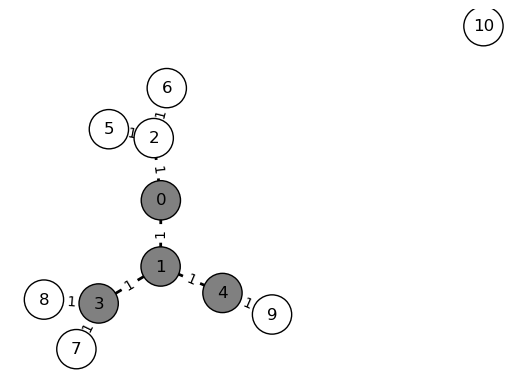

The most likely source nodes are: {1} 
 the corresponding likelyhood probability value is 0.009677001481214836 
 the index of the ovservation time correspond to node 1  is  3


interactive(children=(IntSlider(value=1, description='index of the observation time', layout=Layout(width='500…

the darker the node color, the larger probability for the node to be the source


In [26]:
## provide G and nodes_infected, or use the example by running the cell for constructing the graph below this cell first
MP_weighted(G, nodes_infected)

Construct a graph `G` with weight property, and `nodes_infected` indicating the infected nodes

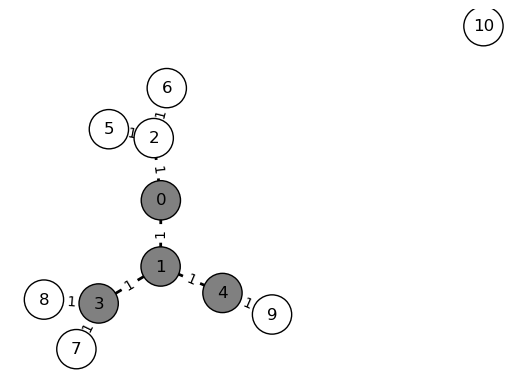

In [4]:

# seed used in "nx.spring_layout(G, seed=pos_SEED)"
pos_SEED=0


# Create an empty tree graph
G = nx.Graph()

# Add 10 nodes to the graph
G.add_nodes_from(range(11))

# Connect the nodes in a tree structure
G.add_edges_from([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9)])

for e in G.edges(data=True):
    G[e[0]][e[1]]["weight"]=1
    
nodes_infected={0,1,3,4}


edge_labels = nx.get_edge_attributes(G,'weight')
    

# Set the node colors
node_colors = ['gray' if i in nodes_infected else 'white' for i in range(G.number_of_nodes())]

# Draw the graph
pos = nx.spring_layout(G, seed=pos_SEED)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors= 'black')
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in range(G.number_of_nodes())}, font_size=12)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off')
plt.show()

In [4]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 1}), (0, 2, {'weight': 1}), (1, 3, {'weight': 1}), (1, 4, {'weight': 1}), (2, 5, {'weight': 1}), (2, 6, {'weight': 1}), (3, 7, {'weight': 1}), (3, 8, {'weight': 1}), (4, 9, {'weight': 1})])

In [48]:
print(nodes_infected)

{0, 1, 3, 4}



Required input:  
 - G: an undirected graph constructed by networkx， with property "weight" storing the edge weight.
 - 'nodes_infected': the set indicating the infected nodes



In [7]:
"""
Construct the parent and child relation between nodes after selecting a node as source.
"""
source=0
parent={} # 'key:value' pair where 'value' is the parent node for node 'key'
child={} #'key:value' pair where 'value' is the set of child nodes for node 'key'
depth={} # 
nodes_waiting_child=set() # nodes haven't assigned child
b_uninfected=set() #susceptible nodes at final observation; uninfected nodes which have infected neighbors
b_infected=set() #infected nodes which have uninfected neighbors
leaf_infected=set() # the leaf infected nodes

parent[source]=None
depth[source]=0
nodes_waiting_child.add(source)
while len(nodes_waiting_child)!=0:
    i=nodes_waiting_child.pop()
    child[i]= set(j for j in G.neighbors(i) if j not in parent.keys())
    is_leaf = True
    for j in child[i]:
        parent[j]=i
        if j in nodes_infected:
            depth[j]=depth[i]+1
            nodes_waiting_child.add(j)
            is_leaf = False
        else:
            b_uninfected.add(j)
            b_infected.add(i)
    if is_leaf==True:
        leaf_infected.add(i)
    # print(i, child[i])
print(parent,child,b_uninfected,b_infected,depth,leaf_infected,sep="\n")

{0: None, 1: 0, 2: 0, 3: 1, 4: 1, 8: 3, 7: 3, 9: 4}

{0: {1, 2}, 1: {3, 4}, 3: {8, 7}, 4: {9}}

{8, 9, 2, 7}

{0, 3, 4}

{0: 0, 1: 1, 3: 2, 4: 2}

{3, 4}


In [8]:
## https://www.cnblogs.com/liam-ji/p/11979964.html
## https://blog.csdn.net/whjkm/article/details/81949356
## Discrete FFT for convolution of a and b
def rfft_convolve(a, b):
    ''' return discrete convolution array of arrays a and b by fft
    '''
    #here we only deal with the case len(a)==len(b)
    if len(a)!=len(b):
        print("Warning. The arrays a and b in fft has different lenghth")
    n = len(a) + len(b) -1
    N = 2 ** (int(np.log2(n))+1)
    A = np.fft.rfft(a, N)
    B = np.fft.rfft(b, N)
    return np.fft.irfft(A*B)[:(n+1)//2]


In [9]:
 
static_num_child_not_ready={}
static_nodes_ready=set() # nodes whose children nodes all can be ready with messages, i.e. nodes that have no child nodes 
static_nodes_received=set()

# only deal with infected nodes, since uninfected nodes in b_uninfected is always ready
for i in nodes_infected:
    
    if len(child[i])==0:
        static_num_child_not_ready[i]=0
        static_nodes_ready.add(i)
    else:
        static_num_child_not_ready[i]=len(child[i])

In [10]:
print(static_num_child_not_ready,static_nodes_ready,static_num_child_not_ready)

{0: 2, 1: 2, 3: 2, 4: 1} set() {0: 2, 1: 2, 3: 2, 4: 1}


In [11]:
"""
'T_max' is the upbound of the ovservation time
'T_positions' is a list whose i-th element is integer (i+1), used for getting T=T_max*T_positions[i] as observation time when we want to check the most likly sourceis the overservation time. 
'num_intervals': the number of intervals we want to discretize [0,T].
'message' is a list, whose i-th (i>=1) element is a set storing the messages in the graph for the i-th overservation time T=T_max*i/(len(T_positions)) we want to test, and the 'key:value' pair in the set stores the message the node 'key' to pass to its parent node. Each message is a list whose length depends on the discretized time.
'result' is a list, whose i-th (i>=1) element is a set, and the 'key:value' pair in the set is the probability for node 'key' to be the source when the observation/spreading time is T=T_max*i/(len(T_positions))
"""
"""
T_positions causes a bit of confusion and diffuculty in programming in the following.
T_max is the maximum possible observation time (total spreading time) we will consider. Since we need to test on different times to maximize the likelihood over time, we want to set different observation time T. T_positions is for getting the index(position) of the critical time, and at the same time we can iterate over T_position and use it as index for 'message'and 'result'.
Currently, T_positions has the form [1,2,3,4], which decide, and we will consider overservation time T=T_max*t_pos/len(T_positions) for t_pos in T_positions, limited to homogeneous critical times.
A better way is to use a new variable T_observe, i.e., T_observe=[2,2.5,3,5] to give the exact observation time, and use T_observe[T_positions[i]] to get the i-th critical time.
Pay attention to the difference between observation time and the time decides by'num_intervals'. 'num_intervals' is a variable specifies number of intervals to discritize the time T (pay attention to the difference with T_max) for messages, since the compute can't store a function of time.
"""

T_max=5
# T_positions=[1,2,3,4]
T_positions=[i for i in range(1,11)]

message=[None]*(len(T_positions)+1)
result=[None]*(len(T_positions)+1)


for t_pos in T_positions:
    num_child_not_ready=static_num_child_not_ready.copy()
    nodes_ready=static_nodes_ready.copy()
    nodes_received=static_nodes_received.copy()
        
    message[t_pos]={}
    result[t_pos]={}

    T=T_max*t_pos/len(T_positions) # total time, or observation time
    num_intervals=20
    t_of_T=[T/num_intervals*i for i in range(0, num_intervals+1)]

    # currently nodes_ready are infected nodes with no child nodes
    nodes_no_child=nodes_ready.copy()
    nodes_received=nodes_ready.copy()
    nodes_ready=set()
    while len(nodes_no_child)!=0: 
        i=nodes_no_child.pop()
        message[t_pos][i]=[1-math.exp(-G[i][parent[i]]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
        i_p=parent[i]
        num_child_not_ready[i_p]-=1
        if num_child_not_ready[i_p] == 0:
            nodes_ready.add(i_p)

    for i in b_uninfected:
        message[t_pos][i]=[math.exp(-G[i][parent[i]]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
        i_p=parent[i]
        num_child_not_ready[i_p]-=1
        if num_child_not_ready[i_p] == 0:
            nodes_ready.add(i_p)

    while len(nodes_ready)!=0:
        i=nodes_ready.pop()
        nodes_received.add(i)
        message[t_pos][i]=[]

        if parent[i] is not None:
            child_product=np.array([1]*len(t_of_T))
            for k in child[i]:
                child_product=np.multiply(child_product, np.array(message[t_pos][k]))
            i_pdf=[G[i][parent[i]]['weight'] * math.exp(-G[i][parent[i]]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
            for j in range(0, num_intervals+1):
                ## not use fft
                message[t_pos][i].append(np.sum(np.multiply(child_product[::-1][:j+1], np.array(i_pdf)[:j+1]))*T/num_intervals)
                ##use fft  
                # message[t_pos][i].append(rfft_convolve(child_product[num_intervals-j:], i_pdf[:j+1])[::-1][0]*T/num_intervals)


            i_p=parent[i]
            num_child_not_ready[i_p]-=1
            if num_child_not_ready[i_p] == 0:
                nodes_ready.add(i_p)    
        else:
            root_product=1
            for k in child[i]:
                if k in nodes_infected:
                    root_product=root_product*np.sum(message[t_pos][k])*T/num_intervals
                else:
                    root_product=root_product*message[t_pos][k][num_intervals] # because for susceptible nodes in b_uninfected, we calculated its CDF in its message[t_pos]

            result[t_pos][source]=root_product.copy()
            # nodes_no_result.remove(source)




In [12]:
message[t_pos][2]

[1.0,
 0.7788007830714049,
 0.6065306597126334,
 0.4723665527410147,
 0.36787944117144233,
 0.2865047968601901,
 0.22313016014842982,
 0.17377394345044514,
 0.1353352832366127,
 0.10539922456186433,
 0.0820849986238988,
 0.06392786120670757,
 0.049787068367863944,
 0.03877420783172201,
 0.0301973834223185,
 0.023517745856009107,
 0.01831563888873418,
 0.014264233908999256,
 0.011108996538242306,
 0.008651695203120634,
 0.006737946999085467]

In [13]:
result

[None,
 {0: 0.0031920156366950932},
 {0: 0.00808081162764457},
 {0: 0.006680641280013004},
 {0: 0.003553068619972021},
 {0: 0.0015011304692722368},
 {0: 0.0005526418837726073},
 {0: 0.00018602667367258172},
 {0: 5.886381039215177e-05},
 {0: 1.781104340711093e-05},
 {0: 5.210981868455816e-06}]

In [ ]:

# 'message_from_parent': 'key:value' pair, where 'value' is a list storing the message the parent in original graph of node 'key' should send to node 'key' when node 'key' becomes the source

message_from_parent=[None]*(len(T_positions)+1)


for t_pos in T_positions:
    ## do not forgot the T and t_of_T when "for t_pos in T_positions" is separated to two part
    T=T_max*t_pos/len(T_positions) # total time
    t_of_T=[T/num_intervals*i for i in range(0, num_intervals+1)]
    
    
    message_from_parent[t_pos]={}
    nodes_to_compute=[i for i in child[source] if i in nodes_infected]
    while len(nodes_to_compute)!=0:
        i=nodes_to_compute.pop()
        i_p=parent[i]

        message_from_parent[t_pos][i]=[]
        # calculate the product of messages from neighbors of i_p except i 
        child_product=np.array([1]*len(t_of_T))
        child_i_p_exclude_i = child[i_p].copy()
        child_i_p_exclude_i.remove(i)
        for k in child_i_p_exclude_i:
            child_product=np.multiply(child_product, np.array(message[t_pos][k]))
        # parent[i_p] is not None means i is not connected to the source
        if parent[i_p] is not None:
            child_product=np.multiply(child_product, np.array(message_from_parent[t_pos][i_p]))

        # message_from_parent[t_pos][i] is the message i_p should send to i
        i_pdf=[G[i][i_p]['weight'] * math.exp(-G[i][i_p]['weight'] * t_of_T[j]) for j in range(0, num_intervals+1)]
        for j in range(0, num_intervals+1):
            ## not use fft
            message_from_parent[t_pos][i].append(np.sum(np.multiply(child_product[::-1][:j+1], np.array(i_pdf)[:j+1]))*T/num_intervals)
            ##use fft  
            # message_from_parent[t_pos][i].append(rfft_convolve(child_product[num_intervals-j:], i_pdf[:j+1])[::-1][0]*T/num_intervals)            
            
        # calculate the probability as if i is the root (source), for message from i_p, should use message_from_parent[t_pos][i]
        root_product=1
        root_product=root_product*np.sum(message_from_parent[t_pos][i])*T/num_intervals
        for k in child[i]:
            if k in nodes_infected:
                root_product=root_product*np.sum(message[t_pos][k])*T/num_intervals
            else:
                root_product=root_product*message[t_pos][k][num_intervals] # because for susceptible nodes in b_uninfected, we calculated its CDF in its message
        # print(t_pos, len(result),result[t_pos])
        result[t_pos][i]=root_product.copy()


         # nodes_no_result.remove(i)
        nodes_to_compute=nodes_to_compute + [j for j in child[i] if j in nodes_infected]


In [15]:
result

[None,
 {0: 0.0031920156366950932,
  1: 0.0004850846462758563,
  4: 0.0031920156366950932,
  3: 0.002574035865435682},
 {0: 0.00808081162764457,
  1: 0.005090085081573266,
  4: 0.00808081162764457,
  3: 0.005121456676324649},
 {0: 0.006680641280013004,
  1: 0.009677001481214836,
  4: 0.006680641280013004,
  3: 0.0032446463847733385},
 {0: 0.003553068619972021,
  1: 0.009242898770100124,
  4: 0.003553068619972021,
  3: 0.0012906985991093564},
 {0: 0.0015011304692722368,
  1: 0.006105885824863585,
  4: 0.0015011304692722368,
  3: 0.0003986826951442454},
 {0: 0.0005526418837726073,
  1: 0.003215788321937638,
  4: 0.0005526418837726073,
  3: 0.00010509041579005836},
 {0: 0.00018602667367258172,
  1: 0.0014560320210853818,
  4: 0.00018602667367258172,
  3: 2.4855266526124204e-05},
 {0: 5.886381039215177e-05,
  1: 0.0005925610525155614,
  4: 5.886381039215177e-05,
  3: 5.434260146641691e-06},
 {0: 1.781104340711093e-05,
  1: 0.00022296040478284396,
  4: 1.781104340711093e-05,
  3: 1.11953402

In [16]:
for i in result:
    if i is not None:
        print(dict(sorted(i.items())))

{0: 0.0031920156366950932, 1: 0.0004850846462758563, 3: 0.002574035865435682, 4: 0.0031920156366950932}

{0: 0.00808081162764457, 1: 0.005090085081573266, 3: 0.005121456676324649, 4: 0.00808081162764457}

{0: 0.006680641280013004, 1: 0.009677001481214836, 3: 0.0032446463847733385, 4: 0.006680641280013004}

{0: 0.003553068619972021, 1: 0.009242898770100124, 3: 0.0012906985991093564, 4: 0.003553068619972021}

{0: 0.0015011304692722368, 1: 0.006105885824863585, 3: 0.0003986826951442454, 4: 0.0015011304692722368}

{0: 0.0005526418837726073, 1: 0.003215788321937638, 3: 0.00010509041579005836, 4: 0.0005526418837726073}

{0: 0.00018602667367258172, 1: 0.0014560320210853818, 3: 2.4855266526124204e-05, 4: 0.00018602667367258172}

{0: 5.886381039215177e-05, 1: 0.0005925610525155614, 3: 5.434260146641691e-06, 4: 5.886381039215177e-05}

{0: 1.781104340711093e-05, 1: 0.00022296040478284396, 3: 1.119534029136166e-06, 4: 1.781104340711093e-05}

{0: 5.210981868455816e-06, 1: 7.903510154678657e-05, 3: 

In [17]:
## store the likelyhood with nodes as keys of a dict. 'result_by_node[i][j]' is the likehood for node i to be the source when observation time is the T_positions[j]-th observation time
result_by_node={}
for i in nodes_infected:
    result_by_node[i]=[]
    for t_pos in T_positions:
        result_by_node[i].append(result[t_pos][i]) # pay attention that the index 0 correspond to t_pos=1

In [18]:
result_by_node

{0: [0.0031920156366950932,
  0.00808081162764457,
  0.006680641280013004,
  0.003553068619972021,
  0.0015011304692722368,
  0.0005526418837726073,
  0.00018602667367258172,
  5.886381039215177e-05,
  1.781104340711093e-05,
  5.210981868455816e-06],
 1: [0.0004850846462758563,
  0.005090085081573266,
  0.009677001481214836,
  0.009242898770100124,
  0.006105885824863585,
  0.003215788321937638,
  0.0014560320210853818,
  0.0005925610525155614,
  0.00022296040478284396,
  7.903510154678657e-05],
 3: [0.002574035865435682,
  0.005121456676324649,
  0.0032446463847733385,
  0.0012906985991093564,
  0.0003986826951442454,
  0.00010509041579005836,
  2.4855266526124204e-05,
  5.434260146641691e-06,
  1.119534029136166e-06,
  2.2016554250481154e-07],
 4: [0.0031920156366950932,
  0.00808081162764457,
  0.006680641280013004,
  0.003553068619972021,
  0.0015011304692722368,
  0.0005526418837726073,
  0.00018602667367258172,
  5.886381039215177e-05,
  1.781104340711093e-05,
  5.210981868455816

In [23]:
## 'max_nodes_t_pos' is a dict; max_nodes_t_pos[i][j] is an integer such that at max_nodes_t_pos[i][j]-th observation time is when node i achives largest likelyhood probability to be the source over all the ovservation times
## 'max_node' are the node has the largest likelyhood probability to be the source, and 'max_value' is the value.
max_nodes_t_pos={}
max_value=0
max_nodes=set()

for k,v in result_by_node.items():
    max_index=np.argmax(v)
    max_nodes_t_pos[k]=max_index+1
    if np.isclose(v[max_index],max_value):
        max_nodes.add(k)
    elif v[max_index]>max_value:               
        max_value=v[max_index]
        max_nodes={k}

print(max_nodes_t_pos)
print('The most likely source nodes are:', max_nodes, '\n', 'the corresponding likelyhood probability value is', max_value, '\n', 
          'the index of the ovservation time correspond to node', list(max_nodes)[0], ' is ', max_nodes_t_pos[list(max_nodes)[0]])

{0: 2, 1: 3, 3: 2, 4: 2}

The most likely source nodes are: {1} 

 the corresponding likelyhood probability value is 0.009677001481214836 

 the index of the ovservation time correspond to node 1  is  3


In [24]:
## result_by_t_pos[i][j] is the likelyhood probability for node j to be the source at i-th observation time.
result_by_t_pos={}
# pay attention that the index 0 correspond to t_pos=1
for t_pos in T_positions:
    result_by_t_pos[t_pos]=[]
    for k in G.nodes():
        result_by_t_pos[t_pos].append(result_by_node[k][t_pos-1] if k in nodes_infected else 0)


In [33]:
# result_by_t_pos

In [34]:
colors_dict=copy.deepcopy(result_by_t_pos)
norm = mpl.colors.Normalize(vmin=0, vmax=max_value, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)


In [40]:
def plot_result_by_t_pos(t_pos_for_plot):
    nx.draw(G, pos=pos, node_color=[mapper.to_rgba(i) for i in colors_dict[t_pos_for_plot]], with_labels=True)
    plt.show()

In [47]:
widgets.interact(plot_result_by_t_pos,t_pos_for_plot=widgets.IntSlider(min=1, max=max(T_positions), step=1, value=1,description="index of the observation time",style={'description_width': 'initial'},layout=widgets.Layout(width='500px')))

print("the darker the node color, the larger probability for the node to be the source")

interactive(children=(IntSlider(value=1, description='index of the observation time', layout=Layout(width='500…

the darker the node color, the larger probability for the node to be the source


 <font color='red'>To be improved:</font> it is better to make the probability values as the color bar, which requires self-defined colormap without normolize the probability values

In [ ]:
-----------------------------------------------

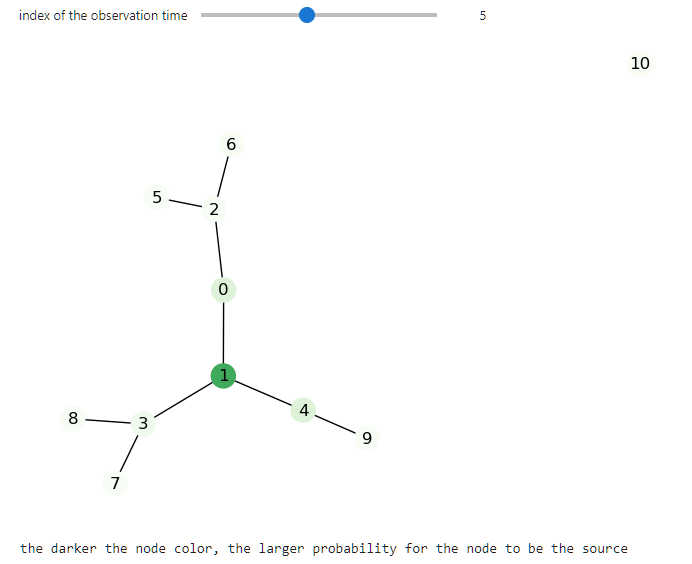

In [35]:
# colors_dict[t_pos_for_plot]

In [36]:
# t_pos_for_plot=2
# nx.draw(G, pos=pos, node_color=[mapper.to_rgba(i) for i in colors_dict[t_pos_for_plot]], with_labels=True)
# plt.show()